In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scienceplots
from bayesfm import BayesFMRegression, fm
from bayesfm.logging import set_verbosity

set_verbosity(logging.INFO)
scienceplots.plt.style.use("scatter")

In [2]:
def generate_cmap(colors, cmap_name="custom_cmap"):
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for vi, ci in zip(values, colors):
        color_list.append((vi / vmax, ci))

    return mcolors.LinearSegmentedColormap.from_list(cmap_name, color_list, 256)


cmthermal = generate_cmap(
    ["#1c3f75", "#068fb9", "#f1e235", "#d64e8b", "#730e22"], "cmthermal"
)

In [3]:
def fm_variables_to_qubo(w, V):
    n = len(w)
    qubo = np.zeros((n, n))
    i, j = np.diag_indices(n)
    qubo[i, j] = w
    qubo += np.triu(np.einsum("if, jf -> ij", V, V), k=1)
    return qubo

def calculate_errors(samples, qubo_true):
    b_samples = samples["b"]
    w_samples = samples["w"]
    V_samples = samples["V"]
    errors = np.zeros(len(b_samples))
    for i in range(len(b_samples)):
        b = b_samples[i]
        w = w_samples[i]
        V = V_samples[i]
        # estim = fm(X_train, b, w, V)
        # error = np.mean((Y_train - estim) ** 2)
        qubo_estim = fm_variables_to_qubo(w, V)
        errors[i] = np.mean((qubo_true - qubo_estim) ** 2)
    return errors

In [5]:
d = 16
k = 15
n_all = 500
n_mcs = 2000
n_warmup = 0
errors = {}
qubo_true = np.random.normal(0, 1, (d, d))
qubo_true = np.triu(qubo_true, k=0)
X_train_all = np.random.choice([0, 1], (n_all, d))
for n in (10, 50, 100, 200, 500):
    X_train = X_train_all[:n]
    Y_train = np.einsum("ij,ki,kj->k", qubo_true, X_train, X_train)

    bfm = BayesFMRegression(
        n_factors=k,
        n_mcs=n_mcs,
        n_warmup=n_warmup,
        save_samples=True,
    )
    bfm.fit(X_train, Y_train)

    samples = bfm.samples
    errors[n] = calculate_errors(samples, qubo_true)

Sampling: 100%|██████████| 2000/2000 [00:05<00:00, 363.14it/s]


In [6]:
plt_indices = np.logspace(0, np.log10(n_mcs - 1), 100, dtype=int)
plt_indices = np.unique(plt_indices)
plot_config = {"s": 15, "facecolor": "none", "linewidth": 1.5}
markers = ["o", "s", "D", "^", "v"]

print(plt_indices)

[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   17   18   19   21   23   25   27   29   31   34   36   39   43
   46   50   54   58   63   68   73   79   85   92  100  108  116  126
  136  146  158  171  185  199  215  232  251  271  293  316  341  369
  398  430  464  501  542  585  631  682  736  795  859  927 1001 1081
 1167 1261 1361 1470 1587 1714 1851 1999]


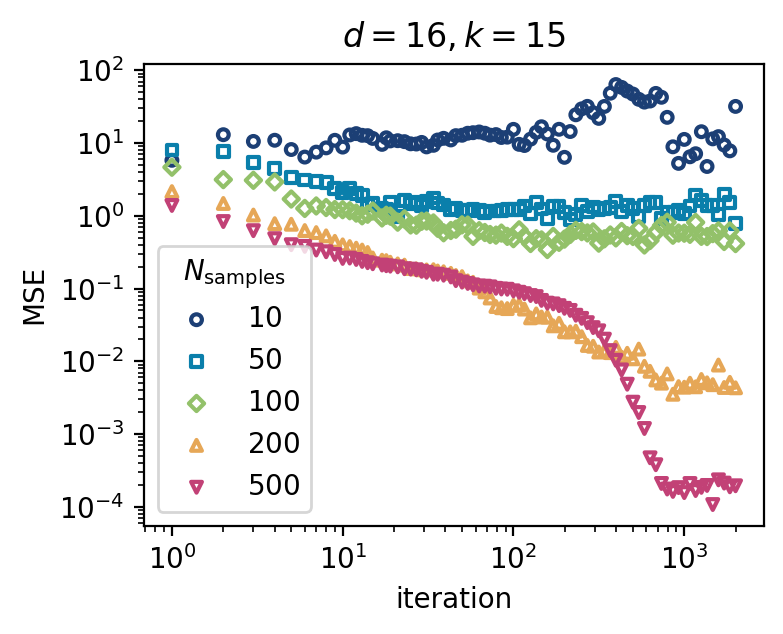

In [12]:
n_mcs = 1000
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot(111)

num_plots = len(errors)
for i in range(num_plots):
    n = list(errors.keys())[i]
    errs = errors[n]
    ax.scatter(
        plt_indices,
        errs[plt_indices],
        label=fr"${n}$",
        color=cmthermal(i / num_plots),
        marker=markers[i],
        **plot_config,
    )
ax.legend(title=r"$N_\text{samples}$")
ax.set_title(r"$d=16, k=15$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("iteration")
ax.set_ylabel("MSE")
plt.show()